In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
import itertools as it
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import embed_signal, simulate_vdp, compute_VAR_p_over_lamb, construct_dictionary, perform_stability_analysis, get_stability_results, predict_EDMD, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Simulate VDP

In [3]:
# dt = 0.001
# total_time = 3000
# mu_vals=np.array([0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5])
# method = 'scipy'
# subsample = True
# verbose = 2
# signals, taus, delayed_mis = simulate_vdp(dt, total_time, mu_vals, method, subsample, verbose)

In [6]:
# pd.to_pickle({'signals': signals, 'taus': taus, 'delayed_mis': delayed_mis, 'dt': dt, 'method': method}, "vdp_full_data.pkl")
ret = pd.read_pickle("vdp_full_data.pkl")
signals = ret['signals']
taus = ret['taus']
delayed_mis = ret['delayed_mis']
dt = ret['dt']
method = ret['method']

In [7]:
mu_vals = [float(key.split(" ")[-1]) for key in list(signals.keys())]

# Testing Some Stuff

In [5]:
# # ADD THE MAIN NONLINEARITY
# for key, signal in signals.items():
#     signals[key] = np.hstack([signal, np.reshape(np.multiply(signal[:, 0]**2, signal[:, 1]), (-1, 1))])

In [8]:
# ------------------
# VAR(p)
# ------------------

method = 'VAR(p)'
# lags = np.array([25])
lags = np.arange(1, 26)
N = list(signals.values())[0].shape[1]
D = N*lags + 1
print(f"dictionary dimension is {D}")

use_lamb_for_full_results=True
trim_CIs = True
# lamb_vals = [0, 0.001, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10, 15, 20, 25, 50, 75, 100]
# lamb_vals = [0, 1e-12, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 1.5, 2, 3, 5, 10, 25, 50, 100, 250, 500]
# lamb_vals = 1e-3
lamb_vals = [0, 1e-12, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 2, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60]

kwargs = dict(
    lags=lags,
    method=method,
    lamb=lamb_vals,
    use_lamb_for_full_results=use_lamb_for_full_results,
    trim_CIs=trim_CIs,
)

dictionary dimension is [ 3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49
 51]


In [9]:
dt_effs = np.array([dt*taus[key] for key in taus.keys()])
min_window = np.max(np.hstack([500*dt_effs, 1.5*np.max(D)*dt_effs]))
print(f"Minimum window is {min_window} seconds")
max_window = np.min(10000*dt_effs)
print(f"Maximum window is {max_window} seconds")

Minimum window is 60.5 seconds
Maximum window is 290.0 seconds


In [10]:
# windows = np.arange(100, 275, 25)
# windows = [100]
windows = [75, 100, 125, 150, 175]

T_pred = 1000
num_window_samples = 5

kwargs['T_pred'] = T_pred
kwargs['num_window_samples'] = num_window_samples
kwargs['verbose'] = True

In [11]:
signal_analysis = {}
for key, signal in signals.items():
    print(f"now computing: {key}")
    kwargs['dt'] = dt*taus[key]
    data = signal
    VAR_results, grid_search_df, test_mse_mat, window, p, lamb = perform_stability_analysis(data, windows, **kwargs)
    signal_analysis[key] = dict(
        VAR_results=VAR_results,
        grid_search_df=grid_search_df,
        test_mse_mat=test_mse_mat,
        window=window,
        p=p,
        lamb=lamb
    )

now computing: mu = 0.001


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

now computing: mu = 0.01


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 0.1


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

now computing: mu = 0.2


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 0.5


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 0.75


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 1.0


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

now computing: mu = 1.25


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

now computing: mu = 2.0


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

now computing: mu = 3.0


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

now computing: mu = 4.0


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

now computing: mu = 5.0


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

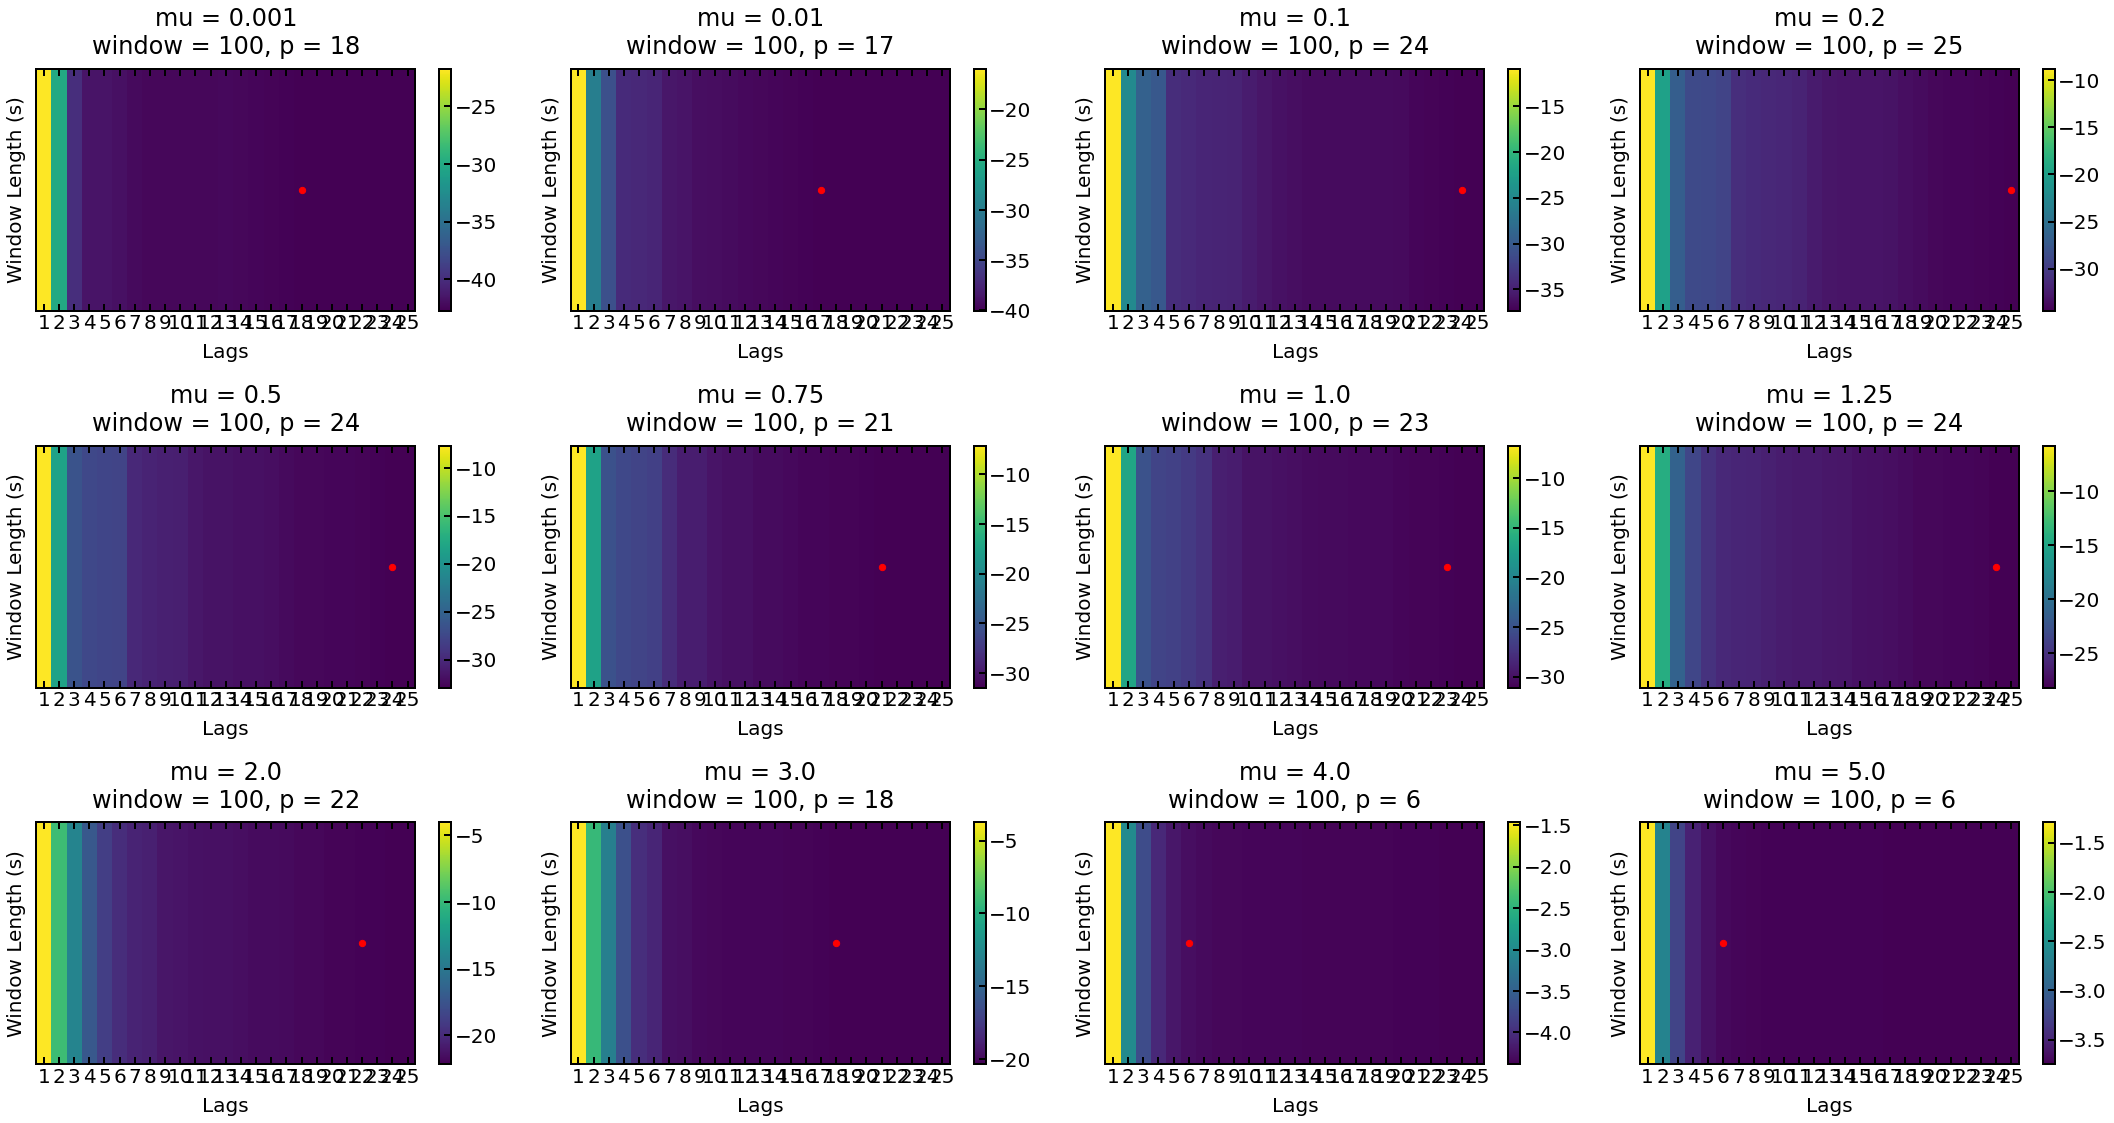

In [194]:

plt.style.use('../../sci_style.py')
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    log_test_mse_mat = np.log(signal_info['test_mse_mat'])
    im = ax.pcolormesh(log_test_mse_mat)
    ax.set_xticks(lags - 0.5)
    ax.set_xticklabels([lag for lag in lags])
    ax.set_yticks(np.arange(1, len(windows), 2) + 0.5)
    ax.set_yticklabels([f"{windows[i]:.2f}" for i in np.arange(1, len(windows), 2)])
    ax.set_xlabel('Lags')
    ax.set_ylabel('Window Length (s)')
    ax.set_title(f"{key}\nwindow = {signal_info['window']}, p = {signal_info['p']}")
    fig.colorbar(im, ax=ax)
    p_ind = np.where(lags == signal_info['p'])[0][0]
    w_ind = np.where(np.array(windows) == signal_info['window'])[0][0]
    ax.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()

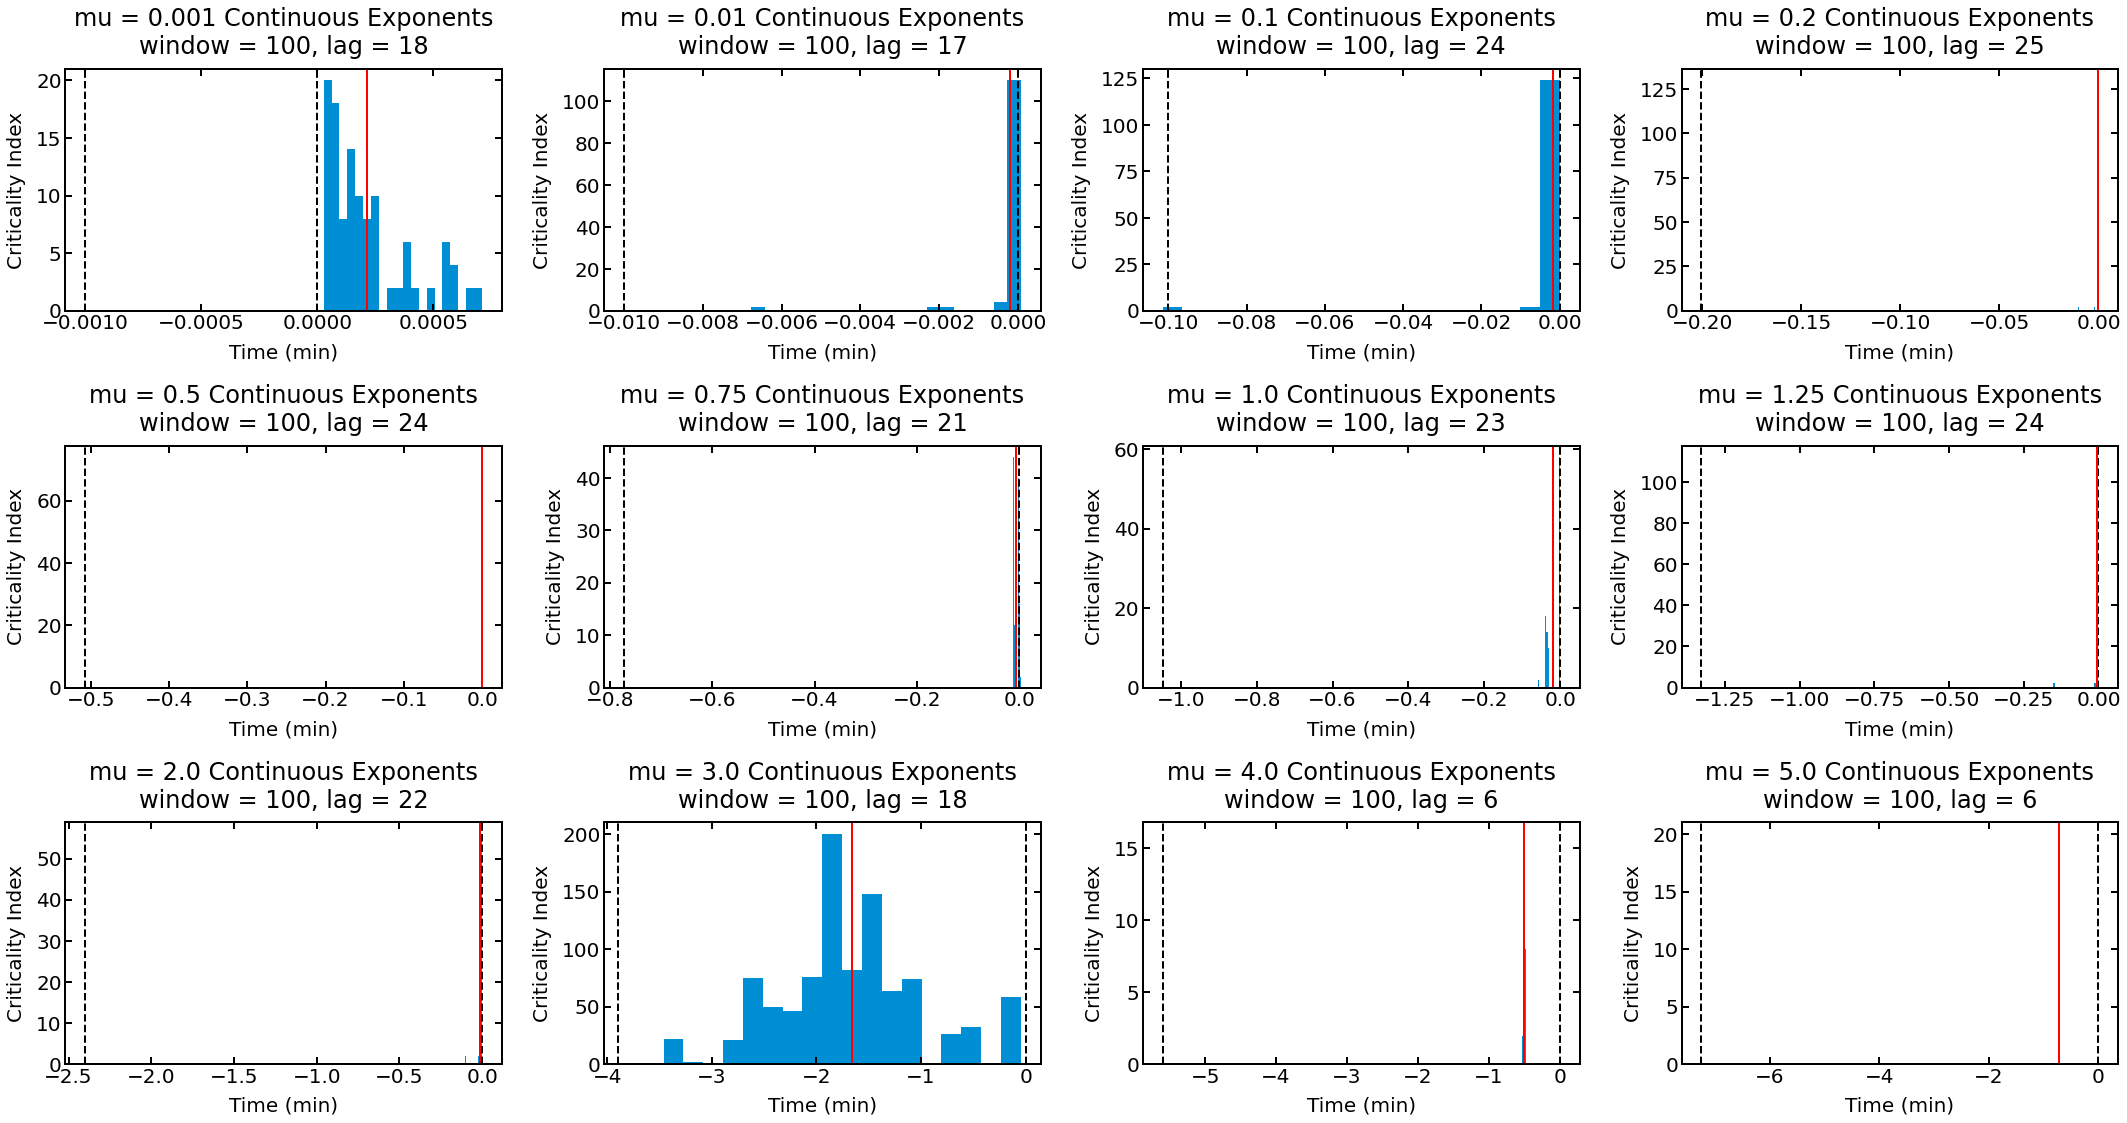

In [359]:
def lambda_2(mu):
    if mu < 2:
        return -mu  - (1/16)*(mu ** 3) + (263/18432)*(mu ** 5)
    elif mu >= 2 and mu <= 4:
        return (-1.2 + (mu - 2)*(-0.1))*mu
    elif mu > 4 and mu <= 5:
        return (-1.4 + (mu - 4)*(-0.05))*mu
#     elif mu == 2:
#         return -1.2*mu
#     elif mu == 3:
#         return -1.3*mu
#     elif mu == 4:
#         return -1.4*mu
#     elif mu == 5:
#         return -1.45*mu
    else:
        return None
# https://arxiv.org/pdf/2111.12198.pdf

rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

pct = 2

mean_vals = []
mean_top_10 = []
mean_bottom_10 = []
for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
        
    VAR_results = signal_info['VAR_results']
    criticalities = np.hstack(VAR_results.criticality_inds)
#     criticalities = criticalities[criticalities > 1e-1]
#     continuous_exps = (criticalities - 1)/(dt*taus[key])
#     continuous_exps = np.hstack(VAR_results['eigs'].apply(lambda x: np.real(np.log(x)/(dt*subsample_step))))
#     print(key)
#     print(criticalities)
    continuous_exps = np.log(criticalities)/(dt*taus[key])
    ax.hist(continuous_exps, bins=20)
#     ax.hist(continuous_exps[continuous_exps > np.percentile(continuous_exps, 90)], bins=20)
    ax.axvline(lambda_2(mu_vals[i]), c='k', linestyle='--')
    ax.axvline(0, c='k', linestyle='--')
    ax.axvline(np.mean(continuous_exps), c='r')
    mean_vals.append(np.mean(continuous_exps))
    mean_bottom_10.append(continuous_exps[continuous_exps <= np.percentile(continuous_exps, pct)].mean())
    mean_top_10.append(continuous_exps[continuous_exps >= np.percentile(continuous_exps, 100 - pct)].mean())
#     mean_bottom_10.append(continuous_exps[np.logical_and(continuous_exps >= np.percentile(continuous_exps, 90), continuous_exps <= np.percentile(continuous_exps, 95))].mean())
#     mean_top_10.append(continuous_exps[continuous_exps >= np.percentile(continuous_exps, 95)].mean())
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Criticality Index')
    ax.set_title(f"{key} Continuous Exponents\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

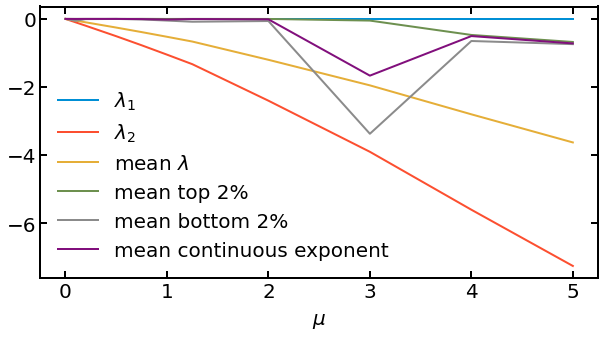

In [360]:
plt.plot(mu_vals, np.zeros(len(mu_vals)), label=r'$\lambda_1$')
plt.plot(mu_vals, [lambda_2(mu_vals[i]) for i in range(len(mu_vals))], label=r'$\lambda_2$')
plt.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], label=r'mean $\lambda$')
plt.plot(mu_vals, np.array(mean_top_10), label=f'mean top {pct}%')
plt.plot(mu_vals, np.array(mean_bottom_10), label=f'mean bottom {pct}%')
plt.plot(mu_vals, np.array(mean_vals), label='mean continuous exponent')
ax = plt.gca()
plt.xlabel(r'$\mu$')
plt.legend()
# ax2 = ax.twinx()
# ax2.plot(mu_vals, p_vals)

p = plt.show()

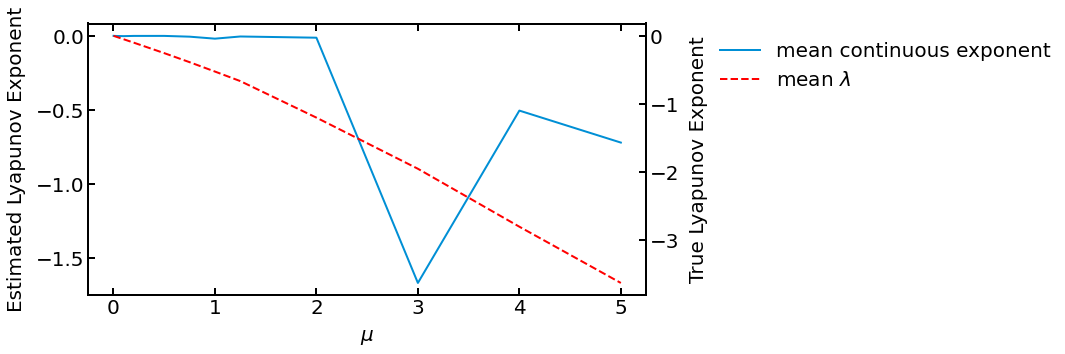

In [361]:

ln1 = plt.plot(mu_vals, np.array(mean_vals), label='mean continuous exponent')
ax = plt.gca()
ax.set_ylabel('Estimated Lyapunov Exponent')
plt.xlabel(r'$\mu$')
ax2 = ax.twinx()
ln2 = ax2.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], c='red', linestyle='--', label=r'mean $\lambda$')
lns = ln1 + ln2
labs = [ln.get_label() for ln in lns]
ax2.set_ylabel('True Lyapunov Exponent')
plt.legend(lns, labs, loc='upper left', bbox_to_anchor=(1.1, 1))

p = plt.show()

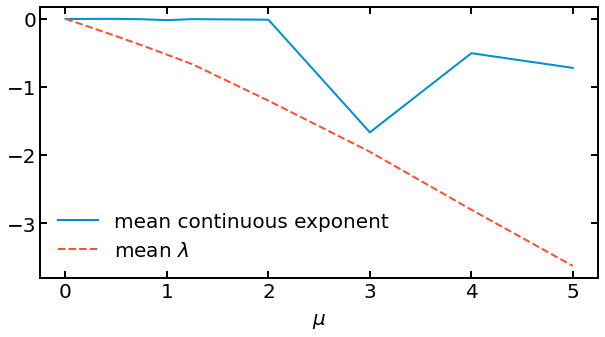

In [362]:

plt.plot(mu_vals, np.array(mean_vals), label='mean continuous exponent')
plt.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], label=r'mean $\lambda$', linestyle='--')
ax = plt.gca()
plt.xlabel(r'$\mu$')
plt.legend()
# ax2 = ax.twinx()
# ax2.plot(mu_vals, p_vals)

p = plt.show()

In [965]:
signals["mu = 5.0"]

array([[-1.73834501,  0.3065616 ],
       [-1.71121777,  0.22143819],
       [-1.68940327,  0.19538074],
       ...,
       [ 2.02147112, -0.0118408 ],
       [ 2.01379821, -0.1079843 ],
       [ 2.00105349, -0.12772123]])

In [350]:
mu = 0.001
key = f'mu = {mu}'
ind = 0

In [351]:
row = signal_analysis[key]['VAR_results'].iloc[0]
def compute_A_mat(coefs, intercept=None):
    p, n = coefs.shape[0], coefs.shape[1]
    if intercept is None:
        A_mat = np.zeros((n*p, n*p))
    else:
        A_mat = np.zeros((n*p + 1, n*p + 1))
    for i in range(p):
        A_mat[:n][:, i*n:(i + 1)*n] = coefs[i]
        if i < p - 1:
            A_mat[(i + 1)*n:(i + 2)*n][:, i*n:(i + 1)*n] = np.eye(n)
    
    if intercept is not None:
        A_mat[:n, -1] = intercept
    
    return A_mat

In [352]:
row.lamb, row.criticality_inds, row.p

(0.0, array([1.00001935, 1.00001935, 1.00000708, 1.00000708]), 18)

In [358]:
lamb_vals = [0, 1e-12, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 2, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60]
mean_crit = []
pred_mse = []
dictionary_kwargs = dict(
    dictionary_method='hermite',
    max_order=2,
    grouped_by=2,
    include_signal=False,
    normalize=True
)
opt_preds = None
opt_lamb = None
min_pred_mse = np.Inf

T_pred = 200
for lamb in tqdm(lamb_vals):
    p = row.p
    signal = signals[key]
#     signal = np.hstack([signal, np.reshape(np.multiply(signal[:, 0]**2, signal[:, 1]), (-1, 1))])
    window_data = signal[row.start_ind:row.end_ind]
    window = window_data.shape[0]
    N = window_data.shape[1]
    
    # ===================
    # VAR(p)
    # ===================
    embedded_signal = embed_signal(window_data, p, 1, direction='reverse')
    X_p = embedded_signal[:-1].T
    Y_p = embedded_signal[1:].T
    X_p = np.vstack([X_p, np.ones((1, window - p))])
    U, S, Vh = np.linalg.svd(X_p)

    S_mat_inv = np.zeros((window - p, N*p + 1))
    S_mat_inv[np.arange(len(S)), np.arange(len(S))] = S/(S**2 + lamb)
    full_mat = Y_p[:N] @ Vh.T @ S_mat_inv @ U.T
    coefs = np.zeros((p, N, N))
    for j in range(p):
        coefs[j] = full_mat[:, j*N:(j + 1)*N]
    intercept = full_mat[:, -1]
    A_mat = compute_A_mat(coefs, intercept)
    criticalities = np.sort(np.abs(np.linalg.eigvals(A_mat)))[::-1]

#     preds, true_vals, pb_mse, pb = predict_VAR_p(signal[row.end_ind - p:row.end_ind + T_pred], coefs, intercept, persistence_baseline=2)
    preds, true_vals, pb_mse, pb = predict_VAR_p(signal[row.end_ind - p:row.end_ind + T_pred], coefs, intercept, persistence_baseline=2, tail_bite=True)
    pred_mse.append(((preds - true_vals)**2).mean())
    
    if pred_mse[-1] < min_pred_mse:
        min_pred_mse = pred_mse[-1]
        opt_preds = preds
        opt_lamb = lamb
    
#     # ===================
#     # EDMD
#     # ===================
#     embedded_signal = embed_signal(window_data, p, 1, direction='reverse')
#     embedded_signal_d, cluster_centers = construct_dictionary(embedded_signal, **dictionary_kwargs)
#     print(embedded_signal_d.shape)
#     X_d = embedded_signal_d[:-1].T
#     Y_d = embedded_signal_d[1:].T
#     D = X_d.shape[0]
    
#     # STANDARD DMD METHOD WITH SVD
#     U, S, Vh = np.linalg.svd(X_d)
#     # set very small singular values to zero
#     # S = S[S > 1e-7]
#     S_mat_inv = np.zeros((X_d.shape[1], D))
#     S_mat_inv[np.arange(len(S)), np.arange(len(S))] = S/(S**2 + lamb)
#     # return Y_d, Vh, S_mat_inv, U, S
#     full_mat = Y_d @ Vh.T @ S_mat_inv @ U.T
#     coefs = full_mat
#     intercept = None
#     A_mat = full_mat
#     criticalities = np.sort(np.abs(np.linalg.eigvals(A_mat)))[::-1]
    
#     predict_type = 'all'
#     preds, true_vals, pb_mse, pb = predict_EDMD(signal[row.end_ind:row.end_ind + 2500], coefs, p, predict_type=predict_type, persistence_baseline=True, **dictionary_kwargs)
#     pred_mse.append(((preds - true_vals)**2).mean())
    
    # ===================
    # FILTER EIGENVALUES
    # ===================

    
    diffs = criticalities[0] - criticalities
    diff = diffs[np.argmax(diffs > 0)]
    eps = np.min([criticalities[0]*0.1, diff])
    dbscan = DBSCAN(eps=eps, min_samples=1)
    labels = dbscan.fit_predict(criticalities.reshape(-1, 1))
    keep_clusters = [0, 1, 2]
    keep_indices = [i for i in range(len(labels)) if labels[i] == max_cluster]
    
    mean_crit.append((np.log(criticalities[keep_indices])/(dt*taus[key])).mean())
    
    

  0%|          | 0/24 [00:00<?, ?it/s]

In [354]:
print(f"opt lamb = {opt_lamb}, min_pred_mse = {min_pred_mse}")

opt lamb = 0, min_pred_mse = 4.6124328312795226e-14


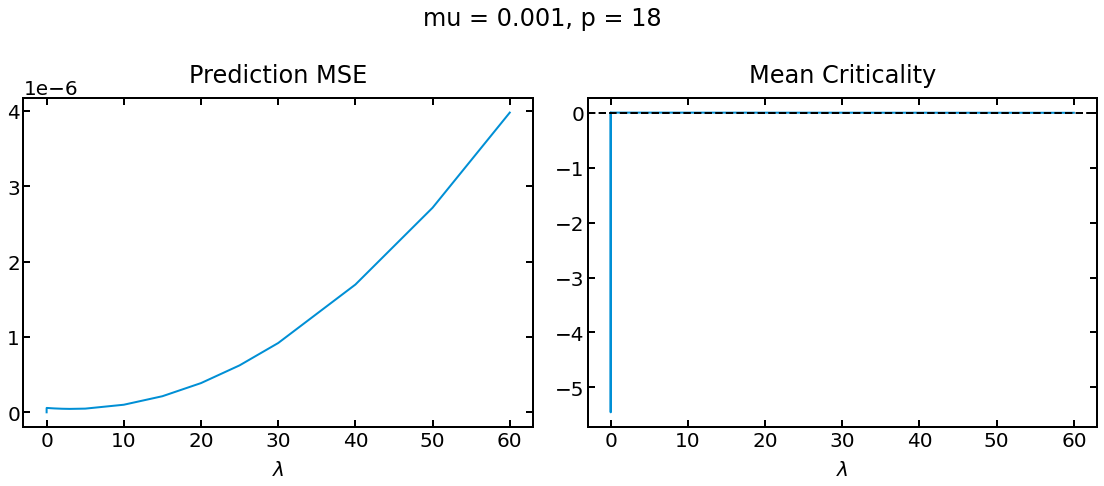

In [355]:
plt.figure(figsize=(16, 7))

start = 0
end = len(lamb_vals)
# end = 3
plt.subplot(1, 2, 1)
plt.plot(lamb_vals[start:end], pred_mse[start:end])
plt.xlabel(r"$\lambda$")
plt.title("Prediction MSE")

plt.subplot(1, 2, 2)
plt.plot(lamb_vals[start:end], mean_crit[start:end])
plt.axhline(lambda_2(mu)/2, linestyle='--', c='k')
plt.xlabel(r"$\lambda$")
plt.title("Mean Criticality")

plt.suptitle(f"mu = {mu}, p = {p}")
plt.tight_layout()
plt.show()

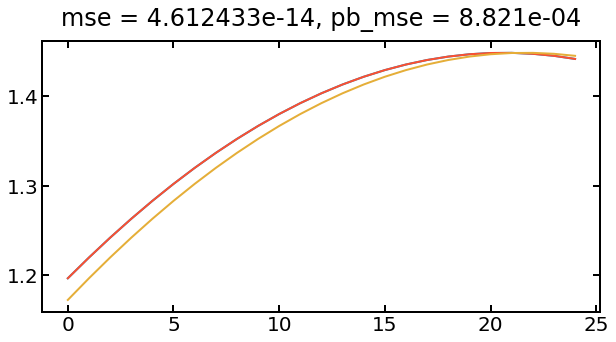

In [357]:
dim = 0
# preds, true_vals, pb_mse, pb = predict_VAR_p(signal[row.end_ind - p:row.end_ind + 500], coefs, intercept, persistence_baseline=2)
plt.plot(true_vals[:, dim])
plt.plot(opt_preds[:, dim])
plt.plot(pb[:, dim])
plt.title(f"mse = {((opt_preds - true_vals)**2).mean():3e}, pb_mse = {pb_mse:.3e}")
plt.show()

# Test Across Mu Values

In [252]:
mu = 0.5
key = f'mu = {mu}'

In [271]:
mu_lyaps = {}
mu_labels = {}
for mu in mu_vals:
    key = f'mu = {mu}'
    # lamb = 1e-12
    # lamb = 1e-4
    row = signal_analysis[key]['VAR_results'].iloc[0]
    lamb = row.lamb
    p = row.p
    print(f"lamb = {lamb}, p = {p}")
    dictionary_kwargs = dict(
        dictionary_method='hermite',
        max_order=2,
        grouped_by=2,
        include_signal=False,
        normalize=True
    )

    # ===================
    # SIGNAL PREP
    # ===================
    signal = signals[key]
    # signal = np.hstack([signal, np.reshape(np.multiply(signal[:, 0]**2, signal[:, 1]), (-1, 1))])
    window_data = signal[row.start_ind:row.end_ind]
    window = window_data.shape[0]
    N = window_data.shape[1]

    # ===================
    # VAR(p)
    # ===================
    embedded_signal = embed_signal(window_data, p, 1, direction='reverse')
    X_p = embedded_signal[:-1].T
    Y_p = embedded_signal[1:].T
    X_p = np.vstack([X_p, np.ones((1, window - p))])
    U, S, Vh = np.linalg.svd(X_p)

    S_mat_inv = np.zeros((window - p, N*p + 1))
    S_mat_inv[np.arange(len(S)), np.arange(len(S))] = S/(S**2 + lamb)
    full_mat = Y_p[:N] @ Vh.T @ S_mat_inv @ U.T
    coefs = np.zeros((p, N, N))
    for j in range(p):
        coefs[j] = full_mat[:, j*N:(j + 1)*N]
    intercept = full_mat[:, -1]
    A_mat = compute_A_mat(coefs, intercept)
    criticalities = np.sort(np.abs(np.linalg.eigvals(A_mat)))[::-1]

    preds, true_vals, pb_mse, pb = predict_VAR_p(signal[row.end_ind:row.end_ind + 2500], coefs, intercept, persistence_baseline=2)
    pred_mse_test = ((preds - true_vals)**2).mean()

    # # ===================
    # # EDMD
    # # ===================
    # embedded_signal = embed_signal(window_data, p, 1, direction='reverse')
    # embedded_signal_d, cluster_centers = construct_dictionary(embedded_signal, **dictionary_kwargs)
    # print(embedded_signal_d.shape)
    # X_d = embedded_signal_d[:-1].T
    # Y_d = embedded_signal_d[1:].T
    # D = X_d.shape[0]

    # # STANDARD DMD METHOD WITH SVD
    # U, S, Vh = np.linalg.svd(X_d)
    # # set very small singular values to zero
    # # S = S[S > 1e-7]
    # S_mat_inv = np.zeros((X_d.shape[1], D))
    # S_mat_inv[np.arange(len(S)), np.arange(len(S))] = S/(S**2 + lamb)
    # # return Y_d, Vh, S_mat_inv, U, S
    # full_mat = Y_d @ Vh.T @ S_mat_inv @ U.T
    # coefs = full_mat
    # intercept = None
    # A_mat = full_mat
    # criticalities = np.sort(np.abs(np.linalg.eigvals(A_mat)))[::-1]

    # predict_type = 'all'
    # preds, true_vals, pb_mse, pb = predict_EDMD(signal[row.end_ind:row.end_ind + 2500], coefs, p, predict_type=predict_type, persistence_baseline=True, **dictionary_kwargs)
    # pred_mse_test = ((preds - true_vals)**2).mean()


    # ===================
    # FILTER EIGENVALUES
    # ===================

    #     dbscan = DBSCAN(eps=np.max(S)*0.1, min_samples=2)
    #     labels = dbscan.fit_predict(S.reshape(-1, 1))
    #     min_cluster = labels[-1]
    #     min_indices = np.where(labels == min_cluster)[0]
    #     noise_indices = np.where(labels == -1)[0]
    #     irrelevant_indices = set(np.hstack([noise_indices, min_indices]))
    #     keep_indices = [i for i in np.arange(len(S)) if i not in irrelevant_indices]

    #     kmeans = KMeans(n_clusters=2)
    #     clusters = kmeans.fit_predict(np.log(S.reshape(-1, 1)))
    #     max_cluster_val = clusters[0]
    #     keep_indices = np.where(clusters == max_cluster_val)[0]

    # dbscan = DBSCAN(eps=S[0]*0.1, min_samples=2)
    # labels = dbscan.fit_predict(S.reshape(-1, 1))
    # min_cluster = labels[-1]
    # keep_indices = [i for i in range(len(labels)) if labels[i] != min_cluster]

    # dbscan = DBSCAN(eps=criticalities[0]*0.1, min_samples=1)
    # labels = dbscan.fit_predict(criticalities.reshape(-1, 1))
    # max_cluster = labels[0]
    # keep_indices = [i for i in range(len(labels)) if labels[i] == max_cluster]

#     diffs = criticalities[0] - criticalities
#     diff = diffs[np.argmax(diffs > 0)]
#     eps = np.min([criticalities[0]*0.1, diff])
#     dbscan = DBSCAN(eps=eps, min_samples=1)
#     labels = dbscan.fit_predict(criticalities.reshape(-1, 1))
#     max_cluster = labels[0]
#     keep_indices = [i for i in range(len(labels)) if labels[i] == max_cluster]
    
    lyaps = np.log(criticalities[criticalities > 0])/(dt*taus[key])
    diffs = lyaps[0] - lyaps
    diff = diffs[np.argmax(diffs > 0)]
    dbscan = DBSCAN(eps=diff, min_samples=1)
    labels = dbscan.fit_predict(lyaps.reshape(-1, 1))
    
    mu_lyaps[key] = lyaps
    mu_labels[key] = labels

lamb = 0.0, p = 18
lamb = 0.0, p = 17
lamb = 0.0, p = 24
lamb = 0.0, p = 25
lamb = 0.0, p = 24
lamb = 0.0, p = 21
lamb = 0.0, p = 23
lamb = 0.0, p = 24
lamb = 0.0, p = 22
lamb = 0.0, p = 18
lamb = 6.000000000000001e-09, p = 6
lamb = 4e-09, p = 6


/tmp/ipykernel_35008/771134469.py:3: RuntimeWarning: Mean of empty slice.
  plt.plot(mu_vals, [mu_lyaps[f"mu = {mu}"][np.isin(mu_labels[f"mu = {mu}"], [1])].mean() for mu in mu_vals], label=f'cluster 1 mean')


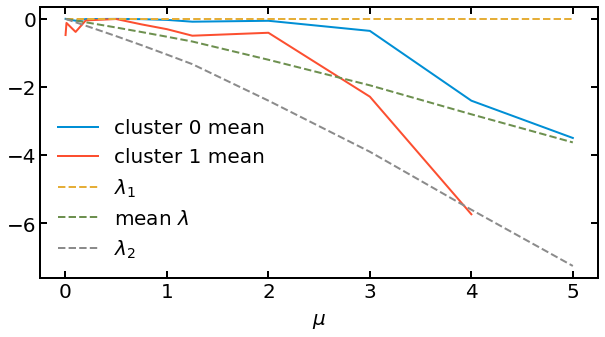

In [299]:
clusters = [0, 1, 2, 3, 4, 5]
plt.plot(mu_vals, [mu_lyaps[f"mu = {mu}"][np.isin(mu_labels[f"mu = {mu}"], [0])].mean() for mu in mu_vals], label=f'cluster 0 mean')
plt.plot(mu_vals, [mu_lyaps[f"mu = {mu}"][np.isin(mu_labels[f"mu = {mu}"], [1])].mean() for mu in mu_vals], label=f'cluster 1 mean')
plt.plot(mu_vals, [0 for mu in mu_vals], linestyle='--', label=r"$\lambda_1$")
plt.plot(mu_vals, [lambda_2(mu)/2 for mu in mu_vals], linestyle='--', label=r"mean $\lambda$")
plt.plot(mu_vals, [lambda_2(mu) for mu in mu_vals], linestyle='--', label=r"$\lambda_2$")
plt.xlabel(r"$\mu$")
plt.legend()
plt.show()

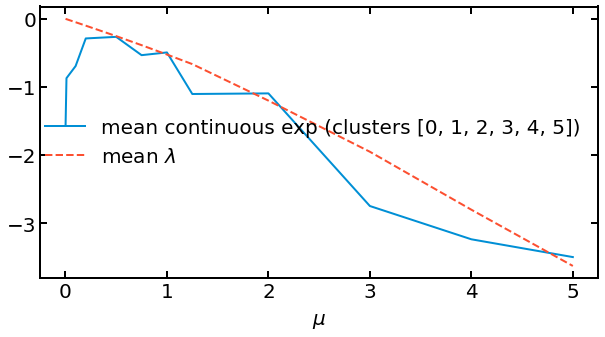

In [298]:
clusters = [0, 1, 2, 3, 4, 5]
plt.plot(mu_vals, [mu_lyaps[f"mu = {mu}"][np.isin(mu_labels[f"mu = {mu}"], clusters)].mean() for mu in mu_vals], label=f'mean continuous exp (clusters {clusters})')
plt.plot(mu_vals, [lambda_2(mu)/2 for mu in mu_vals], linestyle='--', label=r"mean $\lambda$")
plt.xlabel(r"$\mu$")
plt.legend()
plt.show()

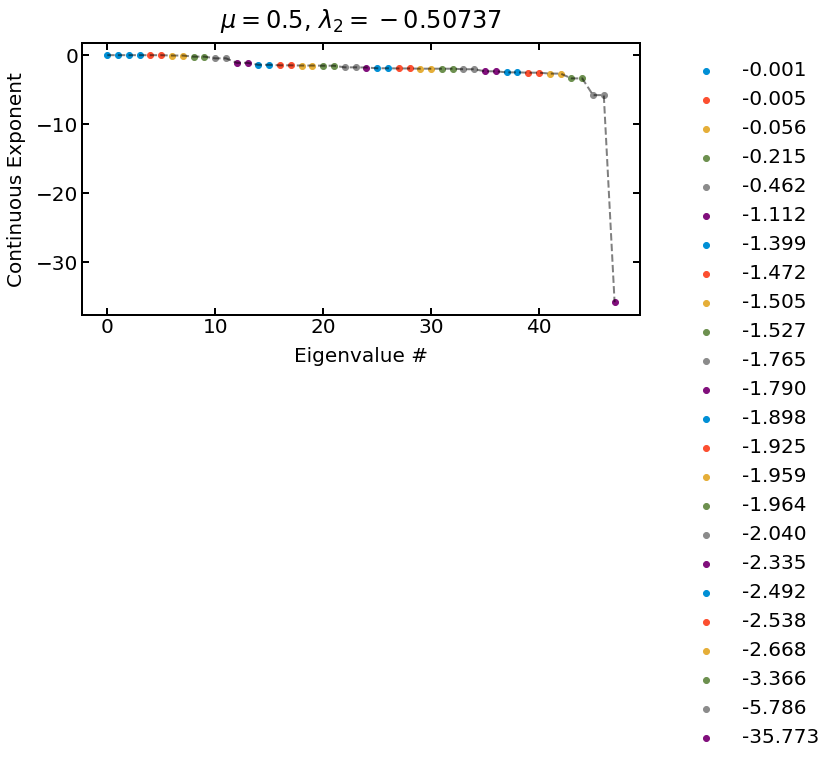

In [254]:
lyaps = np.log(criticalities[criticalities > 0])/(dt*taus[key])

diffs = lyaps[0] - lyaps
diff = diffs[np.argmax(diffs > 0)]
dbscan = DBSCAN(eps=diff, min_samples=1)
labels = dbscan.fit_predict(lyaps.reshape(-1, 1))
plt.plot(lyaps, alpha=0.5, linestyle='--', c='k')
# plt.scatter(np.arange(len(lyaps)), lyaps)
for label in np.unique(labels):
    plt.scatter(np.arange(len(lyaps))[labels == label], lyaps[labels == label], label=f'{lyaps[labels == label].mean():.3f}')
plt.xlabel('Eigenvalue #')
plt.ylabel('Continuous Exponent')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(fr'$\mu = {mu}$, $\lambda_2 = {lambda_2(mu):.5f}$')
plt.show()

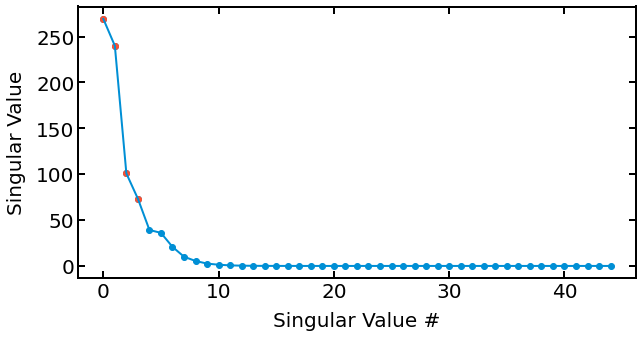

In [235]:
ln1 = plt.plot(np.arange(len(S)), S, label='singular values of data matrix')
plt.scatter(np.arange(len(S)), S)
kmeans = KMeans(n_clusters=2)
# clusters = kmeans.fit_predict(np.log(S.reshape(-1, 1)))
# clusters = kmeans.fit_predict(S.reshape(-1, 1))
# max_cluster_val = clusters[0]
# keep_indices = np.where(clusters == max_cluster_val)[0]


plt.scatter(np.arange(len(S))[keep_indices], S[keep_indices])
# plt.scatter(np.arange(len(S))[:57], S[:57])

# # PLOT THE SINGULAR VALUES OF THE A MATRIX
# _, S_A, _ = np.linalg.svd(A_mat)
# ax = plt.gca()
# ax2 = ax.twinx()
# ln2 = ax2.plot(S_A, linestyle='--', c='orange', label='singular values of A matrix')
# ax2.scatter(np.arange(len(S_A)), S_A, c='orange')
# lns = ln1 + ln2
# labs = [ln.get_label() for ln in lns]
# plt.legend(lns, labs)

plt.xlabel('Singular Value #')
plt.ylabel("Singular Value")
plt.show()

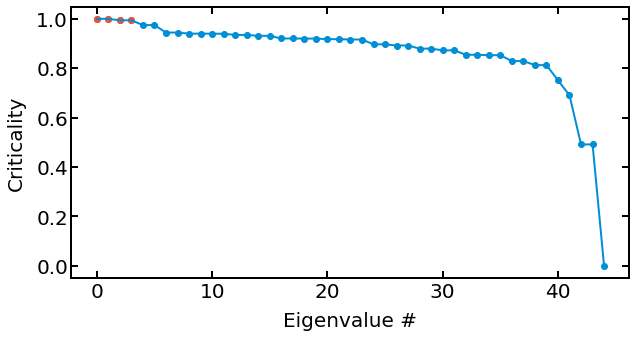

In [236]:
plt.plot(criticalities)
plt.scatter(np.arange(len(criticalities)), criticalities)
plt.scatter(np.arange(len(criticalities))[keep_indices], criticalities[keep_indices])
plt.xlabel('Eigenvalue #')
plt.ylabel('Criticality')
plt.show()

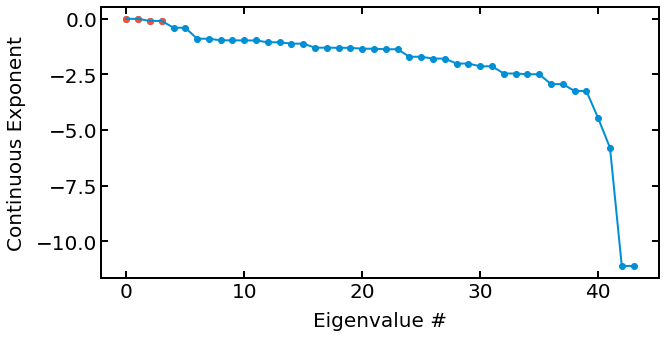

In [237]:
# lyaps = np.log(criticalities[criticalities > 0])/(dt*taus[key])
plt.plot(lyaps)
plt.scatter(np.arange(len(lyaps)), lyaps)
plt.scatter(np.arange(len(lyaps))[keep_indices], lyaps[keep_indices])
plt.xlabel('Eigenvalue #')
plt.ylabel('Continuous Exponent')
plt.show()

In [224]:
lyaps[:5].mean(), lyaps[5:7].mean(), lyaps[7:12].mean(), lambda_2(mu)

(-0.09454150122328533, -2.10291941078875, -2.8335580991662126, -2.4)

In [1306]:
(np.log(criticalities[:57])/(dt*taus[key])).mean()

-2.1177487789476523

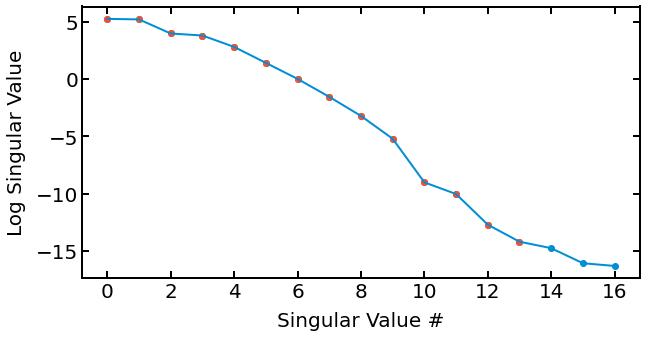

In [1159]:
plt.plot(np.arange(len(S)), np.log(S))
plt.scatter(np.arange(len(S)), np.log(S))
plt.scatter(np.arange(len(S))[keep_indices], np.log(S)[keep_indices])
plt.xlabel('Singular Value #')
plt.ylabel("Log Singular Value")
plt.show()

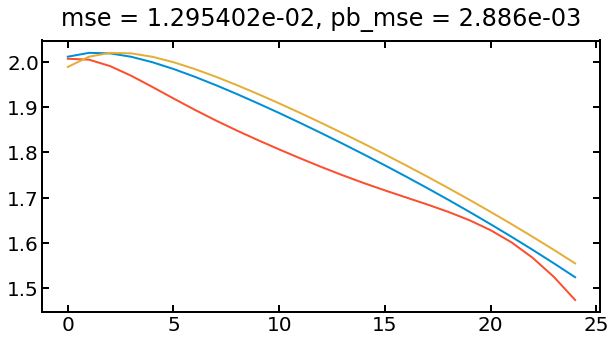

In [335]:
dim = 0
# preds, true_vals, pb_mse, pb = predict_VAR_p(signal[row.end_ind - p:row.end_ind + 500], coefs, intercept, persistence_baseline=2)
plt.plot(true_vals[:, dim])
plt.plot(preds[:, dim])
plt.plot(pb[:, dim])
plt.title(f"mse = {((preds - true_vals)**2).mean():3e}, pb_mse = {pb_mse:.3e}")
plt.show()

In [1084]:
# dim = 0
# preds, true_vals, pb_mse, pb = predict_VAR_p(window_data, coefs, intercept, persistence_baseline=2)
# plt.plot(true_vals[:, dim])
# plt.plot(preds[:, dim])
# plt.plot(pb[:, dim])
# plt.title(f"mse = {((preds - true_vals)**2).mean():3e}, pb_mse = {pb_mse:.3e}")
# plt.show()

# Kernel Method

In [255]:
mu = 0.5
key = f'mu = {mu}'
def compute_A_mat(coefs, intercept=None):
    p, n = coefs.shape[0], coefs.shape[1]
    if intercept is None:
        A_mat = np.zeros((n*p, n*p))
    else:
        A_mat = np.zeros((n*p + 1, n*p + 1))
    for i in range(p):
        A_mat[:n:, i*n:(i + 1)*n] = coefs[i]
        if i < p - 1:
            A_mat[(i + 1)*n:(i + 2)*n, i*n:(i + 1)*n] = np.eye(n)
    
    if intercept is not None:
        A_mat[:n, -1] = intercept
    
    return A_mat

In [256]:
def polynomial_kernel(x, z, alpha, d):
#     if 1 + np.dot(z, x)/(d**2) > 5:
#         print(1 + np.dot(z, x)/(d**2))
#         print(x)
#         print(z)
    return np.power(1 + np.dot(z, x)/(d**2), alpha)

In [257]:
window = 100 # s
window_data = signals[key][:int(window/(dt*taus[key]))]

In [258]:
p = 1
lamb = 1e-3
embedded_signal = embed_signal(window_data, p, 1, direction='reverse')
X_p = embedded_signal[:-1]
Y_p = embedded_signal[1:]
M = X_p.shape[0]

alpha = 5
d = np.linalg.norm(X_p, axis=1).mean()

iterator = tqdm(total=int(M*(M + 1)/2) + M**2)

G = np.zeros((M, M))
for i in range(M):
    for j in range(i + 1):
        G[i, j] = polynomial_kernel(X_p[i], X_p[j], alpha, d)
        G[j, i] = G[i, j]
        
        iterator.update()
        
        
A = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        A[i, j] = polynomial_kernel(Y_p[i], X_p[j], alpha, d)
        
        iterator.update()
iterator.close()

  0%|          | 0/8102626 [00:00<?, ?it/s]

In [259]:
Sigma_2, Q = np.linalg.eigh(G)
assert np.sum(np.abs(G - Q @ np.diag(Sigma_2) @ Q.T)) < 1e-3

In [260]:
argsort_inds = np.argsort(Sigma_2)[::-1]
Sigma_2 = Sigma_2[argsort_inds]
Q = Q[:, argsort_inds]
Sigma_2 = np.clip(Sigma_2, 0, np.Inf) # eigenvalues values should be nonnegative
S = np.sqrt(Sigma_2) 

In [261]:
S_mat_inv = np.zeros((M, M))
inds = S > 0
S_mat_inv[inds, inds] = S[inds]/(S[inds]**2 + lamb)

In [262]:
K = S_mat_inv @ Q.T @ A @ Q @ S_mat_inv

In [263]:
e = np.linalg.eigvals(K)

In [264]:
e

array([0.93234675+0.32231512j, 0.93234675-0.32231512j,
       0.95566875+0.27801878j, ..., 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ])

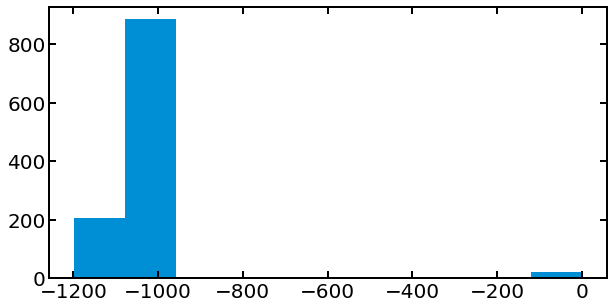

In [265]:
ci = np.sort(np.abs(e[np.abs(e) != 0]))[::-1]
plt.hist(np.log(ci)/(dt*taus[key]))
plt.show()

In [269]:
all_lyaps = np.log(ci[ci > 0])/(dt*taus[key])
lyaps = all_lyaps[all_lyaps > -100]

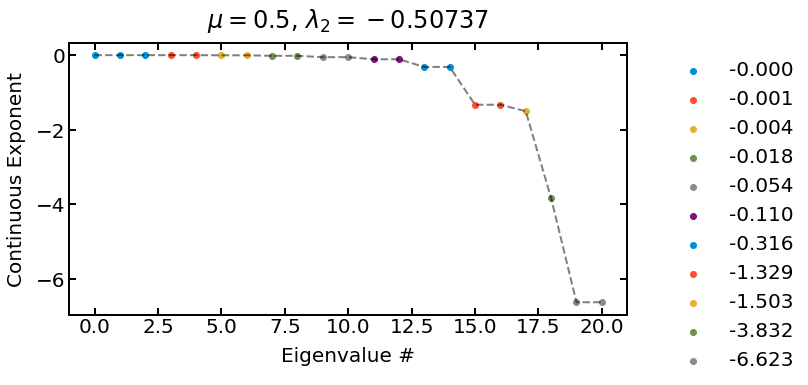

In [270]:
diffs = lyaps[0] - lyaps
diff = diffs[np.argmax(diffs > 0)]
dbscan = DBSCAN(eps=diff, min_samples=1)
labels = dbscan.fit_predict(lyaps.reshape(-1, 1))
plt.plot(lyaps, alpha=0.5, linestyle='--', c='k')
# plt.scatter(np.arange(len(lyaps)), lyaps)
for label in np.unique(labels):
    plt.scatter(np.arange(len(lyaps))[labels == label], lyaps[labels == label], label=f'{lyaps[labels == label].mean():.3f}')
plt.xlabel('Eigenvalue #')
plt.ylabel('Continuous Exponent')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(fr'$\mu = {mu}$, $\lambda_2 = {lambda_2(mu):.5f}$')
plt.show()

In [134]:
lyaps = np.log(ci)[:16]/(dt*taus[key])

In [135]:
lyaps.mean(), lyaps.min(), lyaps.max()

(-0.023008296317621257, -0.12113130374039831, 0.0009171630055171422)

In [136]:
lambda_2(mu)

-0.0010000000624999857

In [107]:
def lambda_2(mu):
    if mu < 2:
        return -mu  - (1/16)*(mu ** 3) + (263/18432)*(mu ** 5)
    elif mu >= 2 and mu <= 4:
        return (-1.2 + (mu - 2)*(-0.1))*mu
    elif mu > 4 and mu <= 5:
        return (-1.4 + (mu - 4)*(-0.05))*mu
#     elif mu == 2:
#         return -1.2*mu
#     elif mu == 3:
#         return -1.3*mu
#     elif mu == 4:
#         return -1.4*mu
#     elif mu == 5:
#         return -1.45*mu
    else:
        return None
# https://arxiv.org/pdf/2111.12198.pdf


-3.9000000000000004